In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

  01 WT 02 sext13 03 sext17 04 sext42 05 sext87 06 efr.fls2   Group
1 0.125     0.375     0.125     0.167     0.250       0.429 Trial01
2 0.500     0.222     0.286     0.167     0.250       0.714 Trial01
3 0.125     0.375     0.375     0.375     0.000       0.429 Trial01
4 0.000     0.571     0.286     0.600     0.429       0.429 Trial01
5 0.000     0.333     0.333     0.222     0.400       0.700 Trial01
6 0.143     0.714     0.222     0.500     0.375       0.500 Trial01
# A tibble: 6 × 3
  ind         Group   values
  <chr>       <chr>    <dbl>
1 01 WT       Trial01  0.125
2 02 sext13   Trial01  0.375
3 03 sext17   Trial01  0.125
4 04 sext42   Trial01  0.167
5 05 sext87   Trial01  0.25 
6 06 efr.fls2 Trial01  0.429
# A tibble: 6 × 3
  Treatment Trial   VALUE
  <chr>     <chr>   <dbl>
1 01 WT     Trial01 0.125
2 01 WT     Trial01 0.5  
3 01 WT     Trial01 0.125
4 01 WT     Trial01 0    
5 01 WT     Trial01 0    
6 01 WT     Trial01 0.143


# A tibble: 6 × 3
  Treatment Trial   VALUE
  <chr>     <chr>   <dbl>
1 01 WT     Trial01 0.125
2 01 WT     Trial01 0.5  
3 01 WT     Trial01 0.125
4 01 WT     Trial01 0    
5 01 WT     Trial01 0    
6 01 WT     Trial01 0.143


[1] 156 158

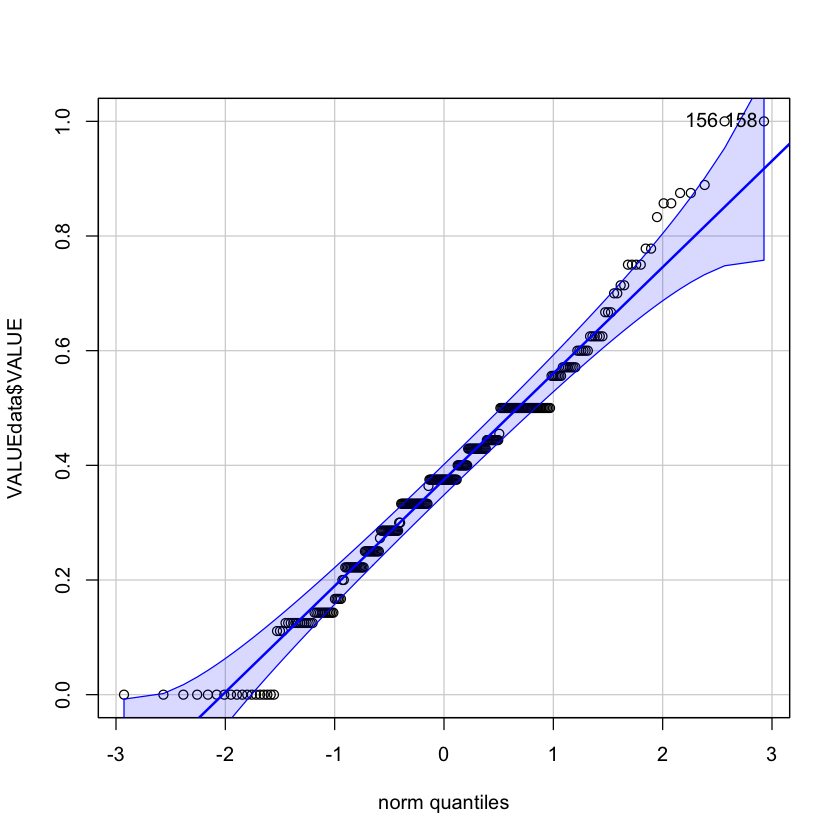

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
  -219.2   -189.8    117.6   -235.2      284 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5781 -0.7127 -0.0588  0.7302  3.2303 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Trial    (Intercept) 0.0002896 0.01702 
 Residual             0.0259937 0.16123 
Number of obs: 292, groups:  Trial, 2

Fixed effects:
                      Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)            0.18164    0.02737  19.62553   6.636 2.03e-06 ***
Treatment02 sext13     0.18469    0.03296 290.12638   5.604 4.88e-08 ***
Treatment03 sext17     0.14117    0.03477 290.02124   4.060 6.32e-05 ***
Treatment04 sext42     0.22063    0.03338 290.08543   6.609 1.85e-10 ***
Treatment05 sext87     0.19551    0.03371 290.41756   5.800 1.73e-08 ***
Treatment06

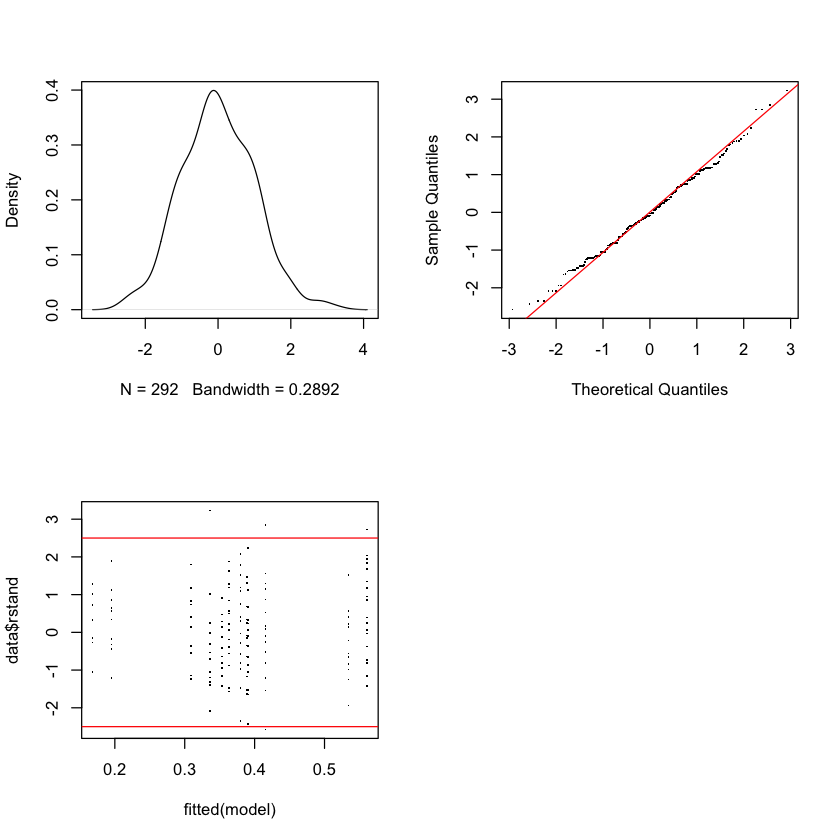

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq           NumDF       DenDF          F value     
 Min.   :3.313   Min.   :0.6627   Min.   :5   Min.   :290.1   Min.   :25.49  
 1st Qu.:3.313   1st Qu.:0.6627   1st Qu.:5   1st Qu.:290.1   1st Qu.:25.49  
 Median :3.313   Median :0.6627   Median :5   Median :290.1   Median :25.49  
 Mean   :3.313   Mean   :0.6627   Mean   :5   Mean   :290.1   Mean   :25.49  
 3rd Qu.:3.313   3rd Qu.:0.6627   3rd Qu.:5   3rd Qu.:290.1   3rd Qu.:25.49  
 Max.   :3.313   Max.   :0.6627   Max.   :5   Max.   :290.1   Max.   :25.49  
     Pr(>F)         
 Min.   :2.615e-21  
 1st Qu.:2.615e-21  
 Median :2.615e-21  
 Mean   :2.615e-21  
 3rd Qu.:2.615e-21  
 Max.   :2.615e-21  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                             Estimate Std. Error z value Pr(>|z|)    
02 sext13 - 01 WT == 0   